# Principal Component Analysis (PCA) on Employee_data

The goal of Principal Component Analysis (PCA) is to reduce the **number of dimensions** of a d-dimensional dataset by projecting it onto a k-dimensional subspace (with k < d) in order to increase the **computational efficiency** while retaining most of the information.

The k dimensions that we keep (eigenvectors) are called "**principal components**".

The PCA approach requires to:

* Standardize the data.
* Obtain the Eigenvectors and Eigenvalues from a Singular Vector Decomposition (SVD).
* Choose the number k of principal components to keep.
* Construct a projection matrix with the selected k eigenvectors.
* Project original dataset to a k-dimensional feature subspace.

Choosing the number k can be done systematically by selecting the components that best describe the variance in our data. The amount of information (variance) contained by each eigenvector can be measured by the **explained variance**.

This notebook will display the explained variance for your dataset and help you choose the right amount of eigenvectors ("principal components").

* [Setup and loading the data](#setup)
* [Preprocessing of the data](#preprocessing)
* [Computation of the PCA](#pca)
* [Display of the explained variance](#explained-variance)
* [Retaining of the most significant components](#final-pca)
* [Visualizing the vectors in the original space](#original-space)

<center><strong>Select Cell > Run All to execute the whole analysis</strong></center>

## Setup and dataset loading <a id="setup" /> 

First of all, let's load the libraries that we'll use

In [2]:
%pylab inline
import sys                          
import pandas as pd, numpy as np             # Data manipulation 
from sklearn.decomposition import PCA        # The main algorithm
from matplotlib import pyplot as plt         # Graphing
import seaborn as sns                        # Graphing
from collections import defaultdict, Counter # Utils
sns.set(style="white")                       # Tuning the style of charts
import warnings                              # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


The first thing we do is now to load the dataset and put aside the three main types of columns:

* Numerics
* Categorical
* Dates

Since analyzing PCA requires to have the data in memory, we are only going to load a sample of the data. Modify the following cell to change the size of the sample.

Also, by default, date features are not kept. Modify the following cell to change that.

In [3]:
dataset_limit = 10000
keep_dates = False

# load the data file within a Pandas dataframe (change the dataset name for a different project)
df = pd.read_excel('Olymp88.xlsx', index_col=0)
df.head()

,r100m,longjump,shot,highjump,r400m,h110m,discus,polevlt,javelin,r1500m,score
Athlete,,,,,,,,,,,
1,11.25,7.43,15.48,2.27,48.90,15.13,49.28,4.7,61.32,268.95,8488
2,10.87,7.45,14.97,1.97,47.71,14.46,44.36,5.1,61.76,273.02,8399
3,11.18,7.44,14.20,1.97,48.29,14.81,43.66,5.2,64.16,263.20,8328
4,10.62,7.38,15.02,2.03,49.06,14.72,44.80,4.9,64.04,285.11,8306
5,11.02,7.43,12.92,1.97,47.44,14.40,41.20,5.2,57.46,256.64,8286


In [4]:
# make a copy of the original dataframe
df_orig = df.copy()    

# dropping now some non relevant fields
#df = df.drop(["gender", "minority", "jobtime"], axis=1)

# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print("Loaded dataset")
print("   Rows: %s" % df.shape[0])
print("   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns)))

Loaded dataset
   Rows: 34
   Columns: 11 (11 num, 0 cat, 0 date)


## Preprocessing of the data <a id="preprocessing" />

Keep the dates as features if requested by the user

In [5]:
columns_to_drop = ['score']

if keep_dates:
    df[date_columns] = df[date_columns].astype(int)*1e-9
else:
    columns_to_drop.extend(date_columns)

print(columns_to_drop)

['score']


Get rid of the columns that contain too many unique values

In [6]:
DROP_LIMIT_ABS = 200
CAT_DROP_LIMIT_RATIO = 0.5
for feature in categorical_columns:
    nu = df[feature].nunique()
    
    if nu > DROP_LIMIT_ABS or nu > CAT_DROP_LIMIT_RATIO*df.shape[0]:
        print("Dropping feature %s with %s values" % (feature, nu))
        columns_to_drop.append(feature)

We then need to impute missing values (or drop the records)

In [7]:
impute = True

if impute:
    # Use mean for numerical features
    for feature in numerical_columns:
        v = df[feature].mean()
        if np.isnan(v):
            v = 0
        print("Filling %s with %s" % (feature, v))
        df[feature] = df[feature].fillna(v)

    # Use mode for categorical features
    for feature in categorical_columns:
        v = df[feature].value_counts().index[0]
        df[feature] = df[feature].fillna(v)

else:        
    # drop records
    df.dropna(inplace=True)


Filling r100m with 11.223529411764705
Filling longjump with 7.095
Filling shot with 13.850882352941175
Filling highjump with 1.9744117647058823
Filling r400m with 49.366176470588236
Filling h110m with 15.10764705882353
Filling discus with 41.90529411764705
Filling polevlt with 4.6764705882352935
Filling javelin with 58.84058823529411
Filling r1500m with 276.1914705882353
Filling score with 7782.85294117647


Drop the columns

In [8]:
print("Dropping the following columns: %s" % columns_to_drop)
df = df.drop(columns_to_drop, axis=1)

Dropping the following columns: ['score']


For all categorical features, we are going to "dummy-encode" them (also sometimes called one-hot encoding).

Basically, a categorical feature is replaced by one column per value. Each created value contains 0 or 1 depending on whether the original value was the one of the column.

In [9]:
# For categorical variables with more than that many values, we only keep the most frequent ones
LIMIT_DUMMIES = 100

# Only keep the top 100 values
def select_dummy_values(train, features):
    dummy_values = {}
    for feature in features:
        values = [
            value
            for (value, _) in Counter(train[feature]).most_common(LIMIT_DUMMIES)
        ]
        dummy_values[feature] = values
    return dummy_values

DUMMY_VALUES = select_dummy_values(df, [x for x in categorical_columns if not x in columns_to_drop])


def dummy_encode_dataframe(df):
    for (feature, dummy_values) in DUMMY_VALUES.items():
        for dummy_value in dummy_values:
            if sys.version_info > (3,0):
                dummy_name = '%s_value_%s' % (feature, dummy_value)
            else:
                dummy_name = u'%s_value_%s' % (feature, dummy_value.decode('utf-8'))
            df[dummy_name] = (df[feature] == dummy_value).astype(float)
        del df[feature]
        print('Dummy-encoded feature %s' % feature)

dummy_encode_dataframe(df)

In [10]:
df

,r100m,longjump,shot,highjump,r400m,h110m,discus,polevlt,javelin,r1500m
Athlete,,,,,,,,,,
1,11.25,7.43,15.48,2.27,48.90,15.13,49.28,4.7,61.32,268.95
2,10.87,7.45,14.97,1.97,47.71,14.46,44.36,5.1,61.76,273.02
3,11.18,7.44,14.20,1.97,48.29,14.81,43.66,5.2,64.16,263.20
4,10.62,7.38,15.02,2.03,49.06,14.72,44.80,4.9,64.04,285.11
5,11.02,7.43,12.92,1.97,47.44,14.40,41.20,5.2,57.46,256.64
6,10.83,7.72,13.58,2.12,48.34,14.18,43.06,4.9,52.18,274.07
7,11.18,7.05,14.12,2.06,49.34,14.39,41.68,5.7,61.60,291.20
8,11.05,6.95,15.34,2.00,48.21,14.36,41.32,4.8,63.00,265.86
9,11.15,7.12,14.52,2.03,49.15,14.66,42.36,4.9,66.46,269.62


<Axes: >

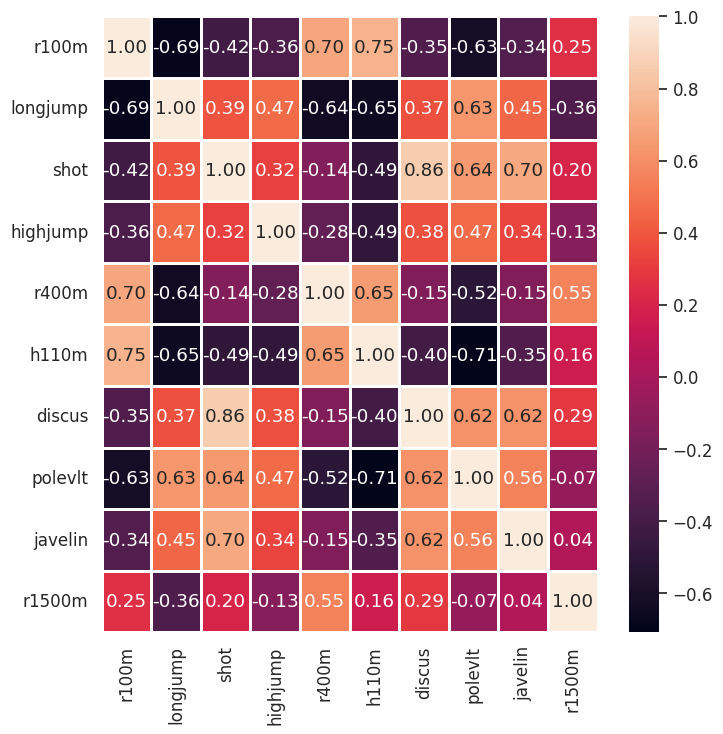

In [11]:
# Heatmap to show correlation between explanatory variables
sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(df.corr(), annot=True, fmt=".2f", linewidths=1, ax=ax)

In [12]:
# Calculate the correlation matrix
corr_matrix = df.corr().abs()

# Unstack the matrix to get variable pairs
corr_pairs = corr_matrix.unstack()

# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs != 1]

# Sort the pairs by correlation value
sorted_pairs = corr_pairs.sort_values(ascending=False)

# Drop duplicate pairs
sorted_pairs = sorted_pairs.drop_duplicates()

# Display the top correlated variable pairs
print("Most highly correlated variable pairs:")
print(sorted_pairs.head())

Most highly correlated variable pairs:
shot     discus     0.856185
h110m    r100m      0.751268
polevlt  h110m      0.708754
shot     javelin    0.702640
r400m    r100m      0.697733
dtype: float64


In [13]:
# Set the correlation threshold
threshold = 0.7

# Create a set to hold variables to drop
vars_to_drop = set()

# Iterate over the sorted pairs
for pair, corr_value in sorted_pairs.items():
    if corr_value > threshold:
        var1, var2 = pair
        # Decide which variable to drop (e.g., drop var2)
        vars_to_drop.add(var2)

# Drop the variables from the dataframe
df_reduced = df.drop(columns=list(vars_to_drop))

print("Variables dropped due to high correlation:")
print(vars_to_drop)

Variables dropped due to high correlation:
{'discus', 'h110m', 'r100m', 'javelin'}


Finally, we rescale the whole data

In [14]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(df)
X_std = ss.transform(df)

## Computation of the PCA <a id="pca" />

Let's "fit" the PCA algorithm (in other words, let's compute the singular value decomposition)

In [15]:
sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X_std)

Here the PCA is a full SVD (k=d, we have not yet applied any "reduction").

## Display of the explained variance of the eigenvectors. <a id="explained-variance" />

The first thing to do after fitting a PCA algorihtm is to plot the **explained variance** of each eigenvector (how much information from the original data does each vector contain).

We also compute how many of these vectors (in order) must be used to retain 90% of the variance of the original dataset (you can change that figure below)

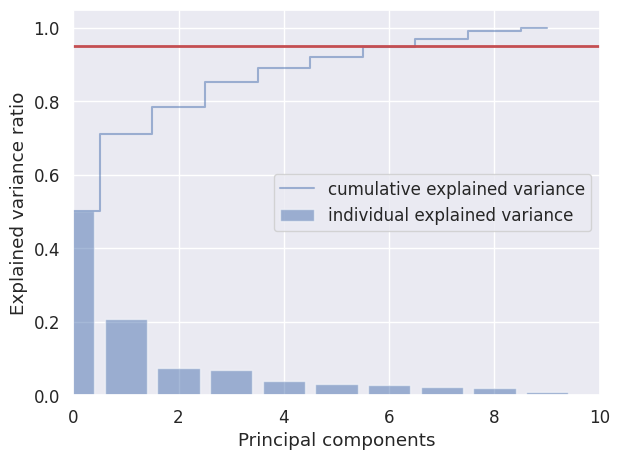

In [16]:
plt.bar(range(sklearn_pca.n_components_), sklearn_pca.explained_variance_ratio_, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(sklearn_pca.n_components_), [sklearn_pca.explained_variance_ratio_[:y].sum() for y in range(1,sklearn_pca.n_components_+1)], alpha=0.5, where='mid',label='cumulative explained variance')
plt.axhline(y=0.95, linewidth=2, color = 'r')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xlim([0, sklearn_pca.n_components_])
plt.legend(loc='best')
plt.tight_layout()


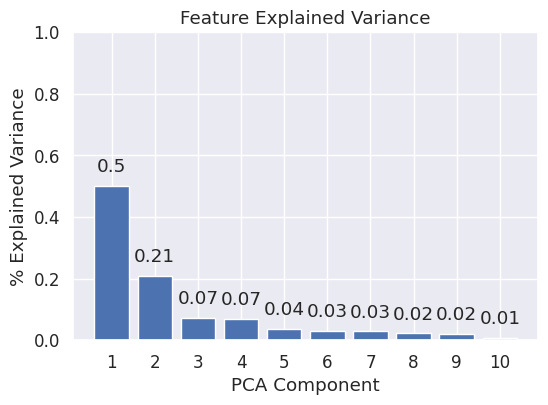

In [17]:
#Bar plot of explained_variance
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(sklearn_pca.n_components_) + 1,
    height = sklearn_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, sklearn_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(sklearn_pca.n_components_) + 1)
ax.set_ylim(0, 1)
ax.set_title('Feature Explained Variance')
ax.set_xlabel('PCA Component')
ax.set_ylabel('% Explained Variance');

In [18]:
# Show data from the chart
print ("Component explained variance:")
variances = pd.DataFrame(sklearn_pca.explained_variance_ratio_, columns=['Variances'])
variances_cum = pd.DataFrame(sklearn_pca.explained_variance_ratio_.cumsum(), columns=['Cumulative'])
frames = [variances, variances_cum] 
df_var = pd.concat(frames, sort=False, axis=1)
df_var

Component explained variance:


,Variances,Cumulative
0,0.502352,0.502352
1,0.207990,0.710342
2,0.073547,0.783889
3,0.068574,0.852463
4,0.037626,0.890089
5,0.030211,0.920299
6,0.028551,0.948850
7,0.022378,0.971228
8,0.020474,0.991702
9,0.008298,1.000000


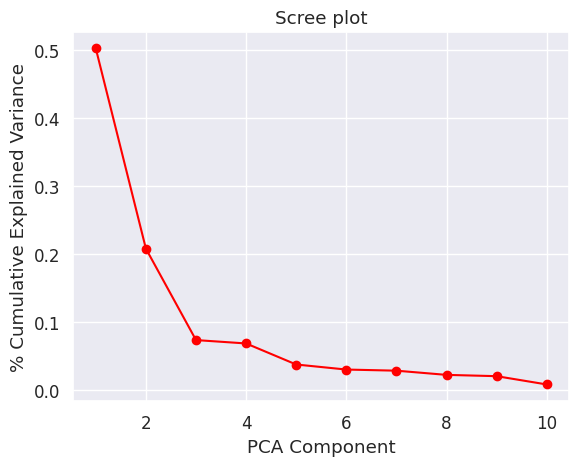

In [19]:
# Scree plot 
plt.plot(
    range(1,len(sklearn_pca.explained_variance_ratio_ )+1),
    sklearn_pca.explained_variance_ratio_,
    c='red', marker='o'
)
 
plt.xlabel('PCA Component')
plt.ylabel('% Cumulative Explained Variance')
plt.title('Scree plot')
plt.show()

## Retaining only some vectors <a id="final-pca" />

You should decide now how many components you want to keep and change the following parameter.

By default we keep the recommended value from the above figure

In [20]:
VARIANCE_TO_KEEP = 0.90
keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
print("Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_)
retained_components_number = keep_recommend

Number of components to keep to retain 90.0% of the variance: 5 out of the original 10


Let's run the PCA again but with a limited number of components this time

In [21]:
sklearn_pca_final = PCA(n_components=retained_components_number)
Y_sklearn_final = sklearn_pca_final.fit_transform(X_std)

## Visualizing the eigenvectors in the original feature space <a id="original-space" />

### Decomposition heatmap

Each of our eigenvectors has a linear decomposition in the original feature space.

To understand which features were the most important, we can see how our eigenvectors are made of each original feature.

In [22]:
# Shows loading factors = correlations between variables and factors
print ("Loading factors:")

dfloading=pd.DataFrame(
    data    = sklearn_pca_final.components_,
    columns = df.columns,
)

index_list=[]
for n in range(retained_components_number):
    index_list.append("PC"+str(n+1))

dfloading.index = index_list
dfloading

Loading factors:


,r100m,longjump,shot,highjump,r400m,h110m,discus,polevlt,javelin,r1500m
PC1,-0.358634,0.361195,0.323991,0.267477,-0.294367,-0.373388,0.306692,0.388947,0.293275,-0.083578
PC2,0.204157,-0.197895,0.394275,-0.007412,0.427198,0.131247,0.416387,0.061929,0.298380,0.545602
PC3,0.300422,0.076949,-0.125214,0.855859,0.232214,0.149139,-0.046053,-0.075492,0.135860,-0.230672
PC4,-0.175914,-0.114807,-0.173586,0.356066,0.016886,-0.387308,-0.041081,0.066216,-0.565922,0.567738
PC5,-0.272176,0.455732,-0.267976,-0.065562,0.285836,-0.054891,-0.445627,-0.155663,0.453519,0.359039


Each variable can be expressed as a lineal combination of Factors. For instance:
educ = 0.452923*PC1 -0.125929*PC2 -0.042881*PC3


Now we hide values lower than 0.2 or 0.3 to display better the relations

In [23]:
# Hide values so that it is clearer
dfloading2 = dfloading.where(abs(dfloading) > 0.3  , "")
dfloading2

,r100m,longjump,shot,highjump,r400m,h110m,discus,polevlt,javelin,r1500m
PC1,-0.358634,0.361195,0.323991,,,-0.373388,0.306692,0.388947,,
PC2,,,0.394275,,0.427198,,0.416387,,,0.545602
PC3,0.300422,,,0.855859,,,,,,
PC4,,,,0.356066,,-0.387308,,,-0.565922,0.567738
PC5,,0.455732,,,,,-0.445627,,0.453519,0.359039


n_components_: 5


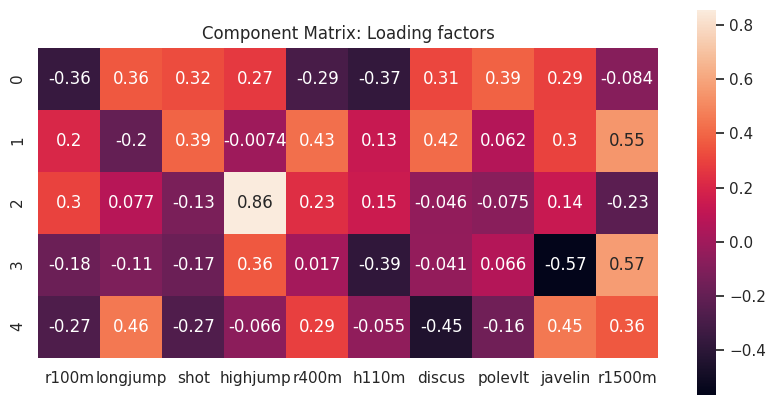

In [24]:
print("n_components_:", sklearn_pca_final.n_components_)
n_components_to_show = 5 if sklearn_pca_final.n_components_ > 5 else sklearn_pca_final.n_components_
n_input_features = sklearn_pca_final.components_.shape[1]  # Get the number of input features

# Create the DataFrame for PCA components
decomp_df = pd.DataFrame(sklearn_pca_final.components_[:n_components_to_show], columns=df.columns[:n_input_features])

# Limit the number of input features to 10 if there are more
if decomp_df.shape[1] > 10:
    decomp_df = decomp_df[decomp_df.columns[:10]]  # Only show up to 10 features

# Plot the heatmap
fig = plt.figure(figsize=(decomp_df.shape[1], n_components_to_show))  # Adjust figure size based on actual data
sns.set(font_scale=1)
sns.heatmap(decomp_df, square=True, annot=True).set(title='Component Matrix: Loading factors')
sns.set(font_scale=1)

plt.show()



### Communalities
In order to calculate communalities (% of information explained from each variable), we need to square the loading factors of each variable.

In [25]:
# Communalities
commun=[]

for col in dfloading.columns:
    commun.append((dfloading.iloc[0:3][col]**2).sum())
    
dfcommun = pd.DataFrame(commun,index=dfloading.columns, columns=["Communalities"])
dfcommun.sort_values("Communalities", ascending=False)

,Communalities
highjump,0.804093
r1500m,0.357876
r400m,0.323073
shot,0.276101
discus,0.269559
r100m,0.260552
javelin,0.193499
h110m,0.178887
longjump,0.175545
polevlt,0.160814


/tmp/ipykernel_3977/3956447377.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(xs[i], ys[i], s=50)
/tmp/ipykernel_3977/3956447377.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(xs[i], ys[i], "  " + varnames)


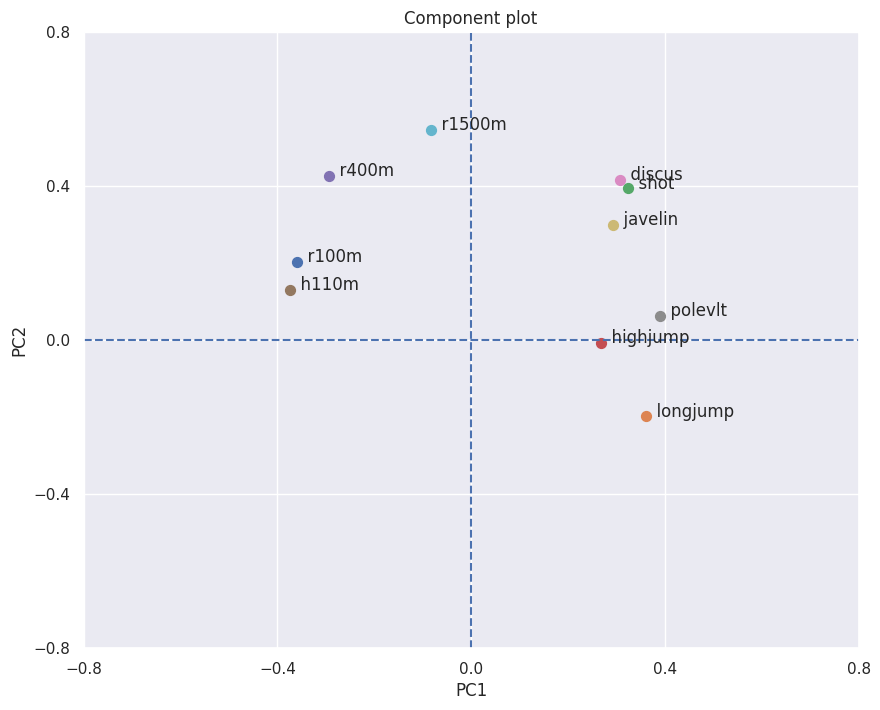

In [26]:
# Get the loadings of x and y axes
dfloadT = dfloading.T

xs = dfloadT.PC1
ys = dfloadT.PC2
 
plt.figure(figsize = (10, 8))
plt.axvline(x = 0, color = 'b', linestyle = 'dashed')
plt.axhline(y = 0, color = 'b', linestyle = 'dashed')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(dfloading.columns):
    plt.scatter(xs[i], ys[i], s=50)
    plt.text(xs[i], ys[i], "  " + varnames)
 
# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
# Show plot
plt.title('Component plot')
plt.savefig('Component plot.png')
plt.show()

### Visualizing projected vectors

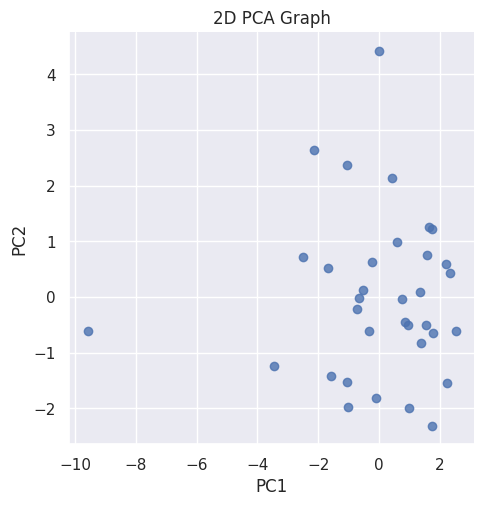

In [27]:
# Create dataframe of two components to display them
sklearn_pca_2 = PCA(n_components=2)
Y_sklearn_2 = sklearn_pca_2.fit_transform(X_std)
indx=np.arange(1, Y_sklearn_2.shape[0]+1)

pca_df_2 = pd.DataFrame(
    data=Y_sklearn_2, 
    columns=['PC1', 'PC2'])

sns.set()
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df_2, 
    fit_reg=False, 
    legend=True
    )
 
plt.title('2D PCA Graph')
plt.show()

In [28]:
# and now it shows the data Projections
pca_df_2

,PC1,PC2
0,2.213423,0.599496
1,2.519867,-0.609117
2,1.786566,-0.637925
3,2.328681,0.432127
4,1.733257,-2.308492
5,2.236245,-1.548489
6,1.585253,0.746641
7,1.547782,-0.511347
8,1.347819,0.089192
9,1.651113,1.249777


In [29]:
# Combine original data with components created
frames = [df_orig, pca_df_2]
dffinal = pd.concat(frames,axis=1)
dffinal.to_excel("Final.xlsx")

## Rotations

In [30]:
from sklearn.decomposition import PCA, FactorAnalysis

n_comps = 2

# Dimension reduction algorithms:
# PCA (Principal Component Analysis): A technique that transforms the data into a set of orthogonal (uncorrelated) components, ordered by the amount of variance they explain in the data.
# Unrotated FA (Factor Analysis): A method that models observed variables and their underlying latent factors. The "unrotated" part means that the factors are not rotated to achieve a simpler structure.
# Varimax FA (Factor Analysis with Varimax Rotation): Similar to unrotated FA, but with an additional step where the factors are rotated using the Varimax method to make the output more interpretable by maximizing the variance of squared loadings of a factor.

methods = [
    ("PCA", PCA()),
    ("Unrotated FA", FactorAnalysis()),
    ("Varimax FA", FactorAnalysis(rotation="varimax")),
]

num_methods = np.arange(3)

for ax, (method, fa) in zip(num_methods, methods):
    fa.set_params(n_components=n_comps)
    ss = StandardScaler().fit(df)
    X_std = ss.transform(df)
    Y_sklearn = fa.fit_transform(X_std)
    
    components = fa.components_.T
    if method == "Unrotated FA":
        df_factor = pd.DataFrame(components, columns = ['PC1','PC2'], index=df.columns)
    elif method == "Varimax FA":
        df_varimax = pd.DataFrame(components, columns = ['PC1','PC2'], index=df.columns)
    else:
        df_pca = pd.DataFrame(components, columns = ['PC1','PC2'], index=df.columns)
        

In [31]:
print("PCA: ")
df_pca.where(abs(df_pca) > 0.3  , "")

PCA: 


,PC1,PC2
r100m,-0.358634,
longjump,0.361195,
shot,0.323991,0.394275
highjump,,
r400m,,0.427198
h110m,-0.373388,
discus,0.306692,0.416387
polevlt,0.388947,
javelin,,
r1500m,,0.545602


In [32]:
print("Unrotated Factor: ")
df_factor.where(abs(df_factor) > 0.3  , "")

Unrotated Factor: 


,PC1,PC2
r100m,0.705988,0.466117
longjump,-0.685742,-0.427738
shot,-0.846376,0.406484
highjump,-0.497511,
r400m,0.514842,0.707587
h110m,0.750041,0.387066
discus,-0.801338,0.41973
polevlt,-0.836797,
javelin,-0.681647,
r1500m,,0.641071


In [33]:
print("Varimax rotation: ")
df_varimax.where(abs(df_varimax) > 0.5  , "")

Varimax rotation: 


,PC1,PC2
r100m,,0.791369
longjump,,-0.748405
shot,-0.924049,
highjump,,
r400m,,0.875063
h110m,,0.753117
discus,-0.895311,
polevlt,-0.602405,-0.595015
javelin,-0.696382,
r1500m,,0.534919


/tmp/ipykernel_3977/1607364176.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(xs[i], ys[i], s=50)
/tmp/ipykernel_3977/1607364176.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(xs[i], ys[i], "  " + varnames)


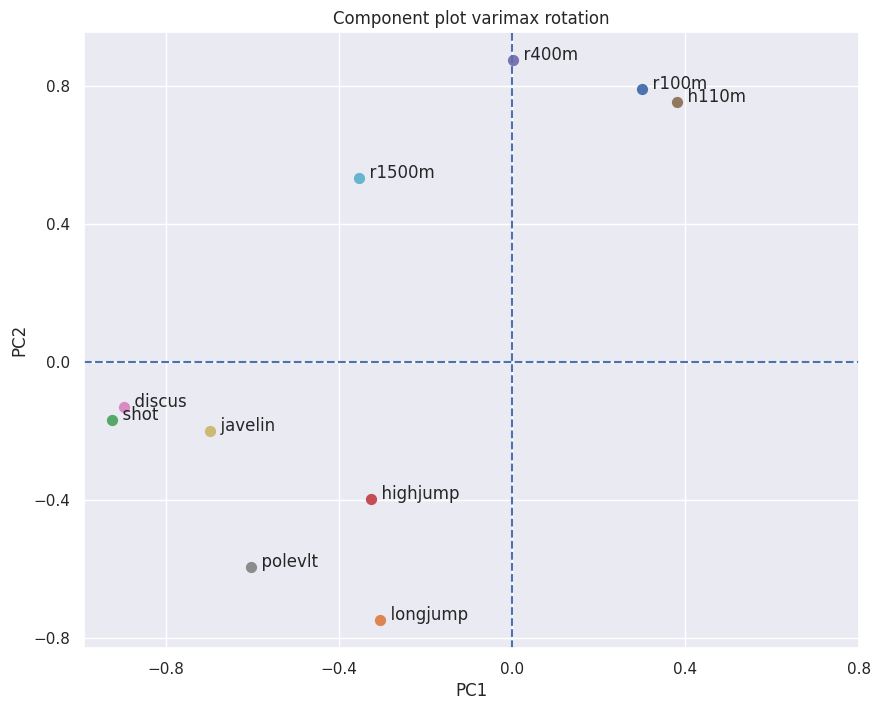

In [34]:
# Represent the component plot rotated
xs = df_varimax.PC1
ys = df_varimax.PC2
 
plt.figure(figsize = (10, 8))
plt.axvline(x = 0, color = 'b', linestyle = 'dashed')
plt.axhline(y = 0, color = 'b', linestyle = 'dashed')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(df_varimax.T):
    plt.scatter(xs[i], ys[i], s=50)
    plt.text(xs[i], ys[i], "  " + varnames)
 
# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
# Show plot
plt.title('Component plot varimax rotation')
plt.savefig('Component plot varimax rotation.png')
plt.show()